In [1]:
import warnings

warnings.filterwarnings('ignore')

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import arviz as az
import bambi as bmb
import hddm_wfpt
import jax
import pytensor

In [6]:
import hssm

In [7]:
RNG = np.random.default_rng(seed=2025)
np.set_printoptions(suppress=True)

In [8]:
pytensor.config.floatX = "float32"
jax.config.update("jax_enable_x64", False)

In [9]:
true_params = {
    "v": 0.5,
    "a": 1.5,
    "z": 0.5,
    "t": 0.5
}

In [10]:
dataset = hssm.simulate_data(model="ddm", theta=true_params, size=1000)

In [11]:
dataset

,rt,response
0,2.824158,1.0
1,1.350275,1.0
2,0.750765,-1.0
3,2.717315,1.0
4,1.270280,1.0
...,...,...
995,1.696805,1.0
996,0.749250,-1.0
997,1.319521,1.0
998,2.075968,1.0


<Axes: xlabel='rt', ylabel='Count'>

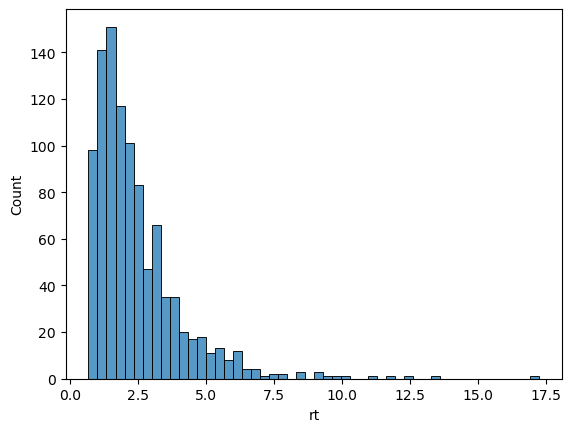

In [12]:
sns.histplot(dataset.rt)

In [13]:
simple_ddm = hssm.HSSM(data=dataset)

Model initialized successfully.


In [14]:
simple_ddm

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 1000

Parameters:

v:
    Prior: Normal(mu: 0.0, sigma: 2.0)
    Explicit bounds: (-inf, inf)

a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)

z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)

t:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)


Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 20.0)

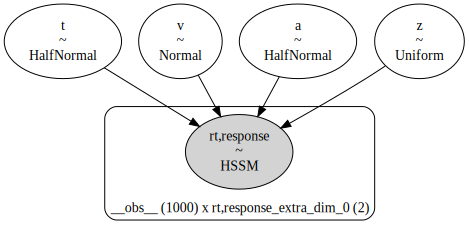

In [15]:
simple_ddm.graph()

In [16]:
simple_ddm_samples = simple_ddm.sample(
    sampler="mcmc",  # type of sampler to choose, 'nuts_numpyro',
    # 'nuts_blackjax' of default pymc nuts sampler
    cores=1,  # how many cores to use
    chains=2,  # how many chains to run
    draws=500,  # number of draws from the markov chain
    tune=1000,  # number of burn-in samples
    idata_kwargs=dict(log_likelihood=True),  # return log likelihood
    mp_ctx="spawn",
)

Using default initvals. 



Initializing NUTS using adapt_diag...
c:\envs\hssm-meta\lib\site-packages\pytensor\link\c\cmodule.py:2959: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Sequential sampling (2 chains in 1 job)
NUTS: [t, a, z, v]


c:\envs\hssm-meta\lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 97 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
c:\envs\hssm-meta\lib\site-packages\pymc\pytensorf.py:958: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(
100%|██████████| 1000/1000 [00:03<00:00, 316.25it/s]


In [17]:
simple_ddm_samples

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

### Diagnostics

In [18]:
az.summary(simple_ddm_samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t,0.498,0.022,0.456,0.538,0.001,0.001,507.0,469.0,1.01
v,0.583,0.035,0.518,0.646,0.001,0.001,724.0,768.0,1.00
z,0.476,0.013,0.451,0.500,0.001,0.000,550.0,481.0,1.00
a,1.477,0.029,1.427,1.532,0.001,0.001,648.0,530.0,1.00


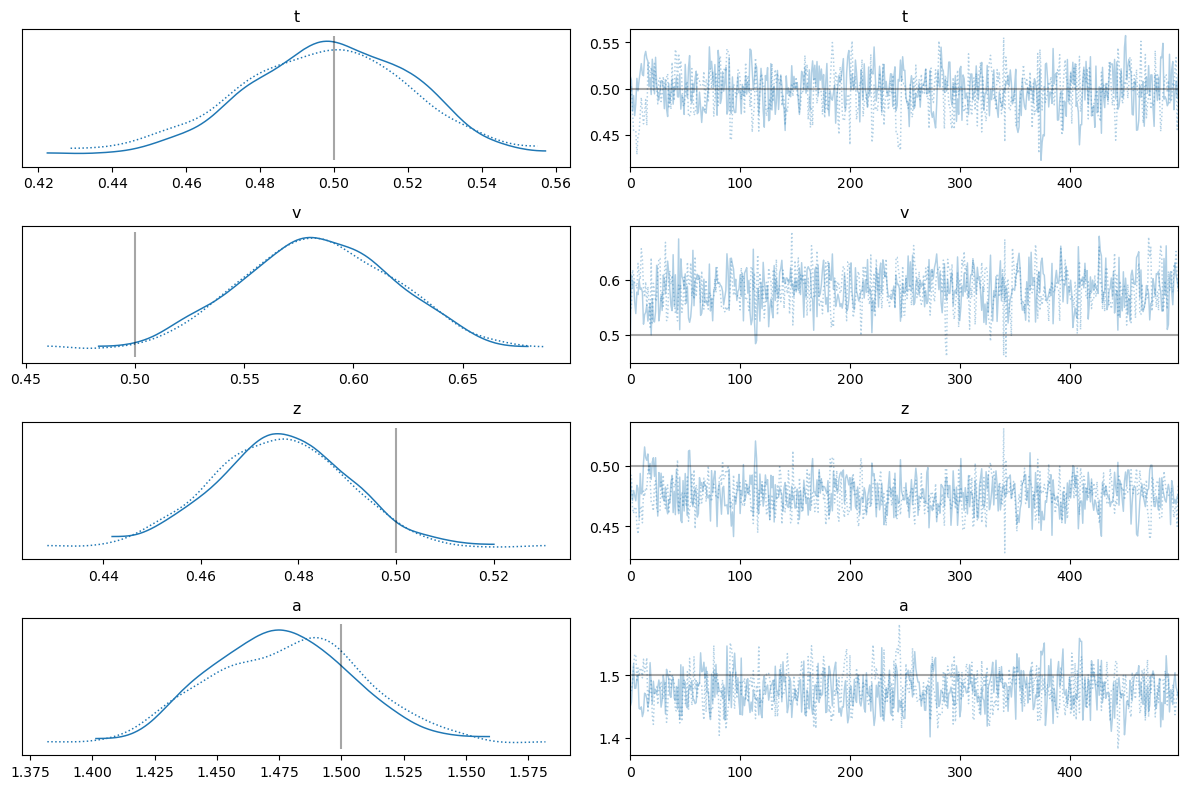

In [20]:
az.plot_trace(simple_ddm_samples, lines=[(key, {}, true_params[key]) for key in true_params],)
plt.tight_layout()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

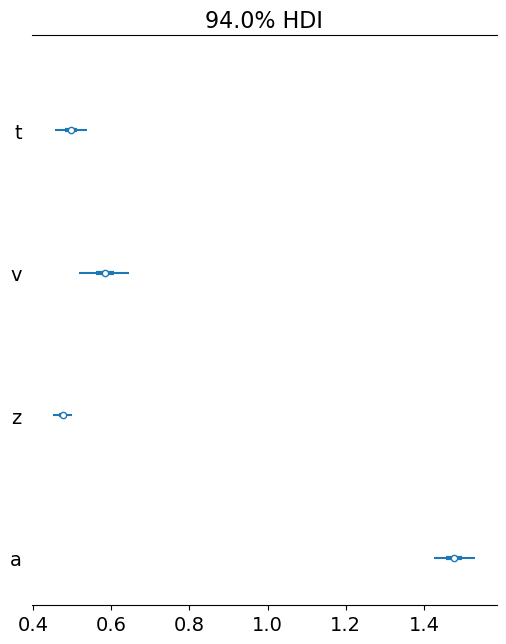

In [22]:
az.plot_forest(simple_ddm.traces, combined=True)

array([[<Axes: ylabel='t'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='v'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='z'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='t', ylabel='a'>, <Axes: xlabel='v'>,
        <Axes: xlabel='z'>, <Axes: xlabel='a'>]], dtype=object)

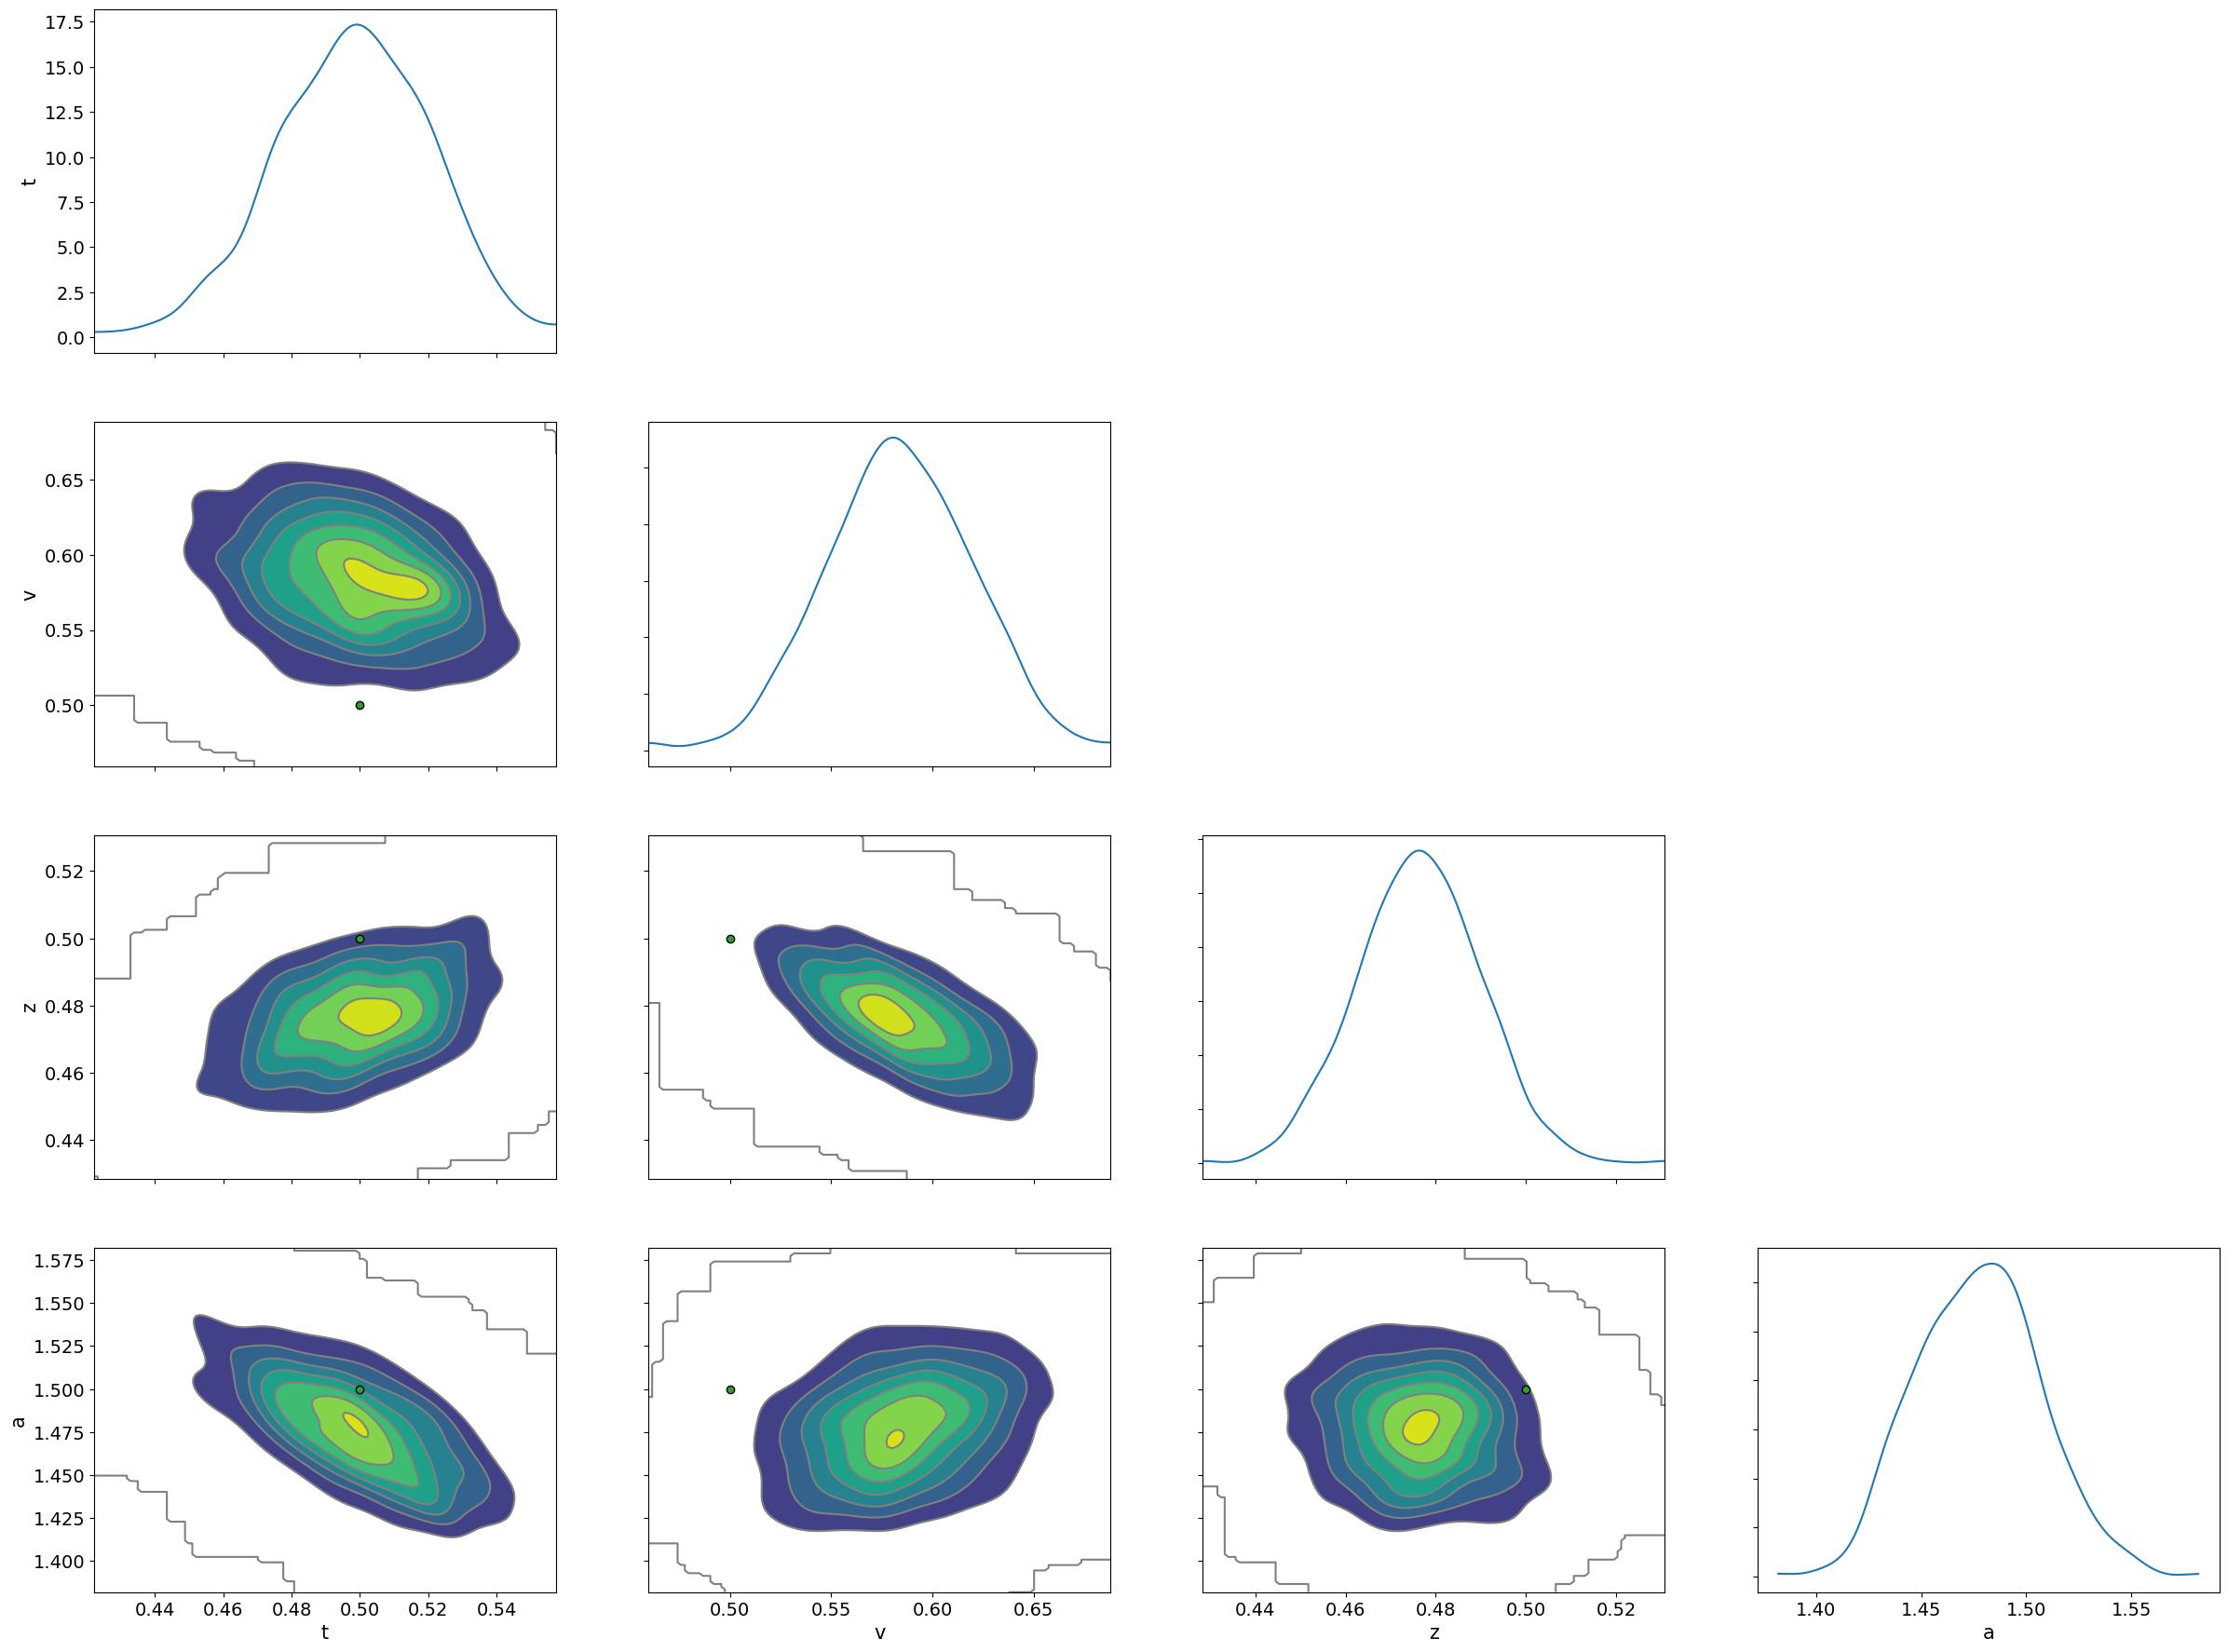

In [24]:
# ArViZ is ugly. Try plotting this in seaborn.


az.plot_pair(
    simple_ddm.traces,
    kind="kde",
    reference_values=true_params,
    marginals=True,
)
